Notebook which produces data required for figure 6. Executes a CIFAR network temporally.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Currently the eager execution mode in dynamic inference leads to GPU memory usage increasing over time. 
# GPU acceleration does not help accelerate the dynamic inference by much so it should be disabled during the
# long inference over 1024 examples to prevent out-of-memory errors on GPU. 

limit_gpus()
set_gpu(None)

In [5]:
dataset = "cifar10"
n_batch = 128
ds_train, ds_test, ds_info = load_dataset(dataset, n_batch)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [6]:
input_shape

(32, 32, 3)

In [7]:
m_repeats = 20

In [8]:
x_train, y_train = get_raw_dat(ds_train)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [9]:
model = Conv2DPhasorModel(input_shape, projection="dot", onehot_offset=0.0, 
                    onehot_phase=0.5,n_hidden=1000, dropout_rate=0.20,
                         repeats=m_repeats,
                         exec_time=20.0,
                         max_step=0.005)

In [11]:
model.dyn_params

{'leakage': -0.2,
 'period': 1.0,
 'window': 0.05,
 'spk_mode': 'gradient',
 'threshold': 0.03,
 'exec_time': 20.0,
 'max_step': 0.005}

In [12]:
model.compile(optimizer="rmsprop")

In [13]:
#train the model with the augmented dataset or load the pre-trained model (below)
#loss = model.train_aug(datagen.flow(x_train, y_train, batch_size=128), 76000)

In [14]:
model.load_weights("models/cifar1.wg")
model.direction = tf.constant(np.load("models/cifar_projection.npz")["a"])

In [15]:
(xs, ys) = next(iter(ds_train))

In [16]:
#make a static call first to build the network shapes
model(xs)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[ 0.05655276,  0.01200876, -0.0137441 , ..., -0.05706671,
         0.01007828, -0.02022297],
       [ 0.03774589,  0.01146928, -0.00653273, ..., -0.01469834,
        -0.01656708,  0.10359748],
       [-0.00304408, -0.00797822,  0.2166489 , ...,  0.00787783,
         0.00233666,  0.04392024],
       ...,
       [-0.02847026, -0.02238577,  0.00318194, ..., -0.01499358,
         0.02291343,  0.03570843],
       [ 0.50240475, -0.00224591, -0.03141884, ...,  0.00614478,
        -0.05217361,  0.01051962],
       [ 0.35792717,  0.01710453, -0.00322679, ...,  0.01610184,
        -0.04836113, -0.01076851]], dtype=float32)>

In [17]:
#model.accuracy(ds_test, False)

In [18]:
# dynamic call

In [19]:
n_batches = 1

In [20]:
#n_batches = 8

In [21]:
n_subsample = n_batch * n_batches

In [22]:
n_subsample

128

In [23]:
x_test, y_test = get_raw_dat(ds_test)

In [24]:
# save each batch's output as it is computed
# dynamic execution with the CIFAR network takes several hours per batch
# this task is also done in the included cifar_execution_script.py which can be run safely e.g. in a screen session

In [25]:
for i in range(n_batches):
    i_start = i * n_batch
    i_stop = (i+1) * n_batch
    print("starting batch " + str(i))
    
    test_subset = tf.data.Dataset.from_tensor_slices((x_test[i_start:i_stop, ...], y_test[i_start:i_stop, ...]))
    test_subset = test_subset.batch(n_batch)
    
    dyn_y = model.evaluate(test_subset, method="dynamic", solver="euler")
    
    filename = "runs/cifar_dyn_batch"+str(i)+(".npz")
    np.savez_compressed(filename, a=dyn_y.numpy())
    

starting batch 0


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 1


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Conv 2


  0%|          | 0/128 [00:00<?, ?it/s]

Dynamic Execution: Dense


100%|██████████| 128/128 [06:33<00:00,  3.08s/it]


In [26]:
#save the labels matching the dataset so ground truth for each sample is known later
trueys = y_test[0:n_subsample,...]
np.savez_compressed("runs/matching_ys.npz", a = trueys)

In [27]:
#run from saved results (can resume from here when results are saved)

In [28]:
trueys = np.load("runs/matching_ys.npz")['a']
trueys = y_test[0:n_subsample,...]

In [29]:
#the true matching labels
trueys

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([6, 7, 0, 2, 9, 5, 9, 7, 2, 7, 0, 3, 7, 1, 2, 7, 5, 8, 0, 2, 0, 8,
       8, 3, 0, 4, 1, 7, 8, 5, 0, 5, 5, 3, 2, 8, 2, 0, 5, 0, 9, 3, 5, 0,
       5, 3, 3, 2, 8, 1, 0, 6, 2, 7, 8, 5, 0, 8, 2, 1, 0, 6, 4, 7, 5, 2,
       8, 0, 2, 8, 9, 1, 0, 5, 2, 3, 5, 4, 2, 5, 0, 1, 8, 3, 4, 6, 0, 7,
       7, 8, 1, 4, 1, 4, 0, 8, 2, 1, 1, 3, 9, 8, 4, 8, 1, 1, 4, 8, 6, 1,
       6, 9, 2, 1, 5, 3, 4, 0, 0, 8, 2, 4, 1, 7, 2, 4, 7, 1])>

In [30]:
all_res = [np.load("runs/cifar_dyn_batch"+str(i)+".npz")["a"] for i in range(n_batches)]

In [31]:
#get the ouput phases for each sample, cycle, and neuron
dyn_yhs0 = tf.concat(all_res, axis=0)

In [32]:
dyn_yhs0.shape

TensorShape([128, 20, 10])

In [33]:
#use the predict function to get the class predicted by the last full cycle
dyn_yhs = model.predict(dyn_yhs0, method="dynamic")

In [34]:
#the predicted labels from dynamic execution for each sample
dyn_yhs.shape

(128,)

In [35]:
dyn_yhs == trueys

<tf.Tensor: shape=(128,), dtype=bool, numpy=
array([ True,  True,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False,  True, False,  True, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False,  True,
        True,  True, False, False,  True, False,  True,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
        True,  True, False, False, False,  Tr

In [36]:
#accuracy of predictions made at each cycle
#last 2 cycles this deep in the network are 'cut off' by the ending time (20.0s) and ignored
all_predictions = np.array([np.mean(model._predict_ind(dyn_yhs0, i) == trueys) for i in range(m_repeats-2)])

In [37]:
dpi=100

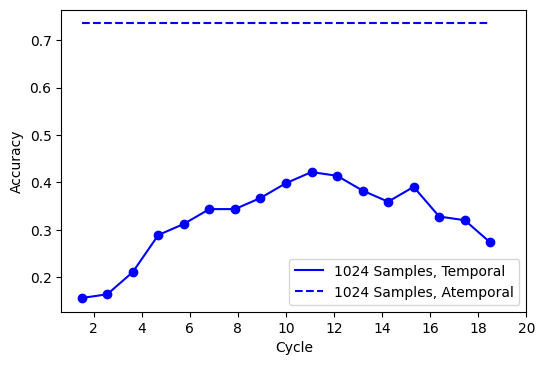

In [38]:
plt.figure(dpi=dpi)
plt.plot(1.5+np.linspace(0, 17 , 17), all_predictions[0:17], label="1024 Samples, Temporal",  color="blue")
plt.plot(1.5+np.linspace(0, 17 , 17), all_predictions[0:17], 'o',  color="blue")
plt.plot(1.5+np.linspace(0, 17 , 17), np.ones(17)*0.7353515625, "--", label="1024 Samples, Atemporal", color="blue")
plt.xticks(np.arange(2,21,2), np.arange(2,21,2))
plt.xlabel("Cycle")
plt.ylabel("Accuracy")
plt.legend()

In [25]:
np.savez_compressed("1024_dyn.npz", a=all_predictions)

In [ ]:
#compute the matching static accuracy

In [91]:
test_x, test_y = get_raw_dat(ds_test)

In [92]:
first_1024x = test_x[0:1024,...]
first_1024y = test_y[0:1024,...]

In [93]:
stat_y = model.call(first_1024x)

In [94]:
statys = model.predict(stat_y)

In [95]:
#the dynamic CIFAR accuracy

In [96]:
dyn_a = np.mean(dyn_yhs == trueys)

In [97]:
statys

<tf.Tensor: shape=(1024,), dtype=int64, numpy=array([1, 1, 9, ..., 4, 3, 4])>

In [98]:
stat_a = tf.reduce_mean(tf.cast(statys == first_1024y, dtype="float"))

In [99]:
#the static CIFAR accuracy

In [100]:
stat_a

<tf.Tensor: shape=(), dtype=float32, numpy=0.73339844>

In [101]:
#the accuracy loss

In [102]:
stat_a - dyn_a

<tf.Tensor: shape=(), dtype=float32, numpy=0.034179688>